# Predicting House Prices

My goal for this notebook is to predict house prices based on a Kaggle dataset of house attributes. This analysis will employ a few different models and will also serve as a discussion on strengths and weakness of the models used.

In [1]:
from datetime import datetime
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, normalize
import sklearn.feature_selection as fs
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import RandomForestRegressor

from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.float_format', lambda x: '%.3f' % x)
random_state = 10

In [2]:
df = pd.read_csv('train.csv')
Y = df['SalePrice']
df = df.drop(['SalePrice'], axis=1)

## Data Processing

Upon doing a quick inspection of the data, I've devised with the following feature handling strategy: 
- variables with less than 20 unique values will be treated as categorical features, with the exception of
    - PoolArea
- the following features have more than 20 distinct values but will be treated as categorical
    - Neighborhood
- the following features have less than 20 unique values, but will more appropriately be treated as continuous features
    - BsmtFullBath
    - BsmtHalfBath
    - FullBath
    - HalfBath
    - BedroomAbvGr
    - KitchenAbvGr
    - TotRmsAbvGrd
    - Fireplaces
    - GarageCars
    - MoSold

In [3]:
not_converted = []
for col in df.columns:
    if (len(df[col].value_counts()) < 20):
        if col != 'PoolArea':
            df[col] = df[col].astype('category')
#             print(col + ' converted to Category')
    else:
        not_converted.append(col)
        
# Categorical variables that have more than 20 distinct values.
df['Neighborhood'] = df['Neighborhood'].astype('category')

# Variables with less than 20 distinct values, that are not categorical. They contain counts, and 
# will be treated as continuous/numeric.
to_convert = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
              'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
              'Fireplaces', 'GarageCars', 'YrSold']

for col in to_convert:
    # convert cols back to int. 
    df[col] = df[col].astype(int)
    
# Note to self - think about how to encode the cyclic 'month' variable

Observations: 
   - The variables that are approximately normally distributed or have a skew, tend to be related to square footage.
   - There are a handful of discrete numerical variables representing counts
   - There are about 9 variables that look like they have a very low-variability in information ie. have a high percentage of one value. These low-variablity features may include some useful signals WRT the target so we'll keep them for now.

### High percentage of NAs

Identifying variables with more than some percentage of NAs

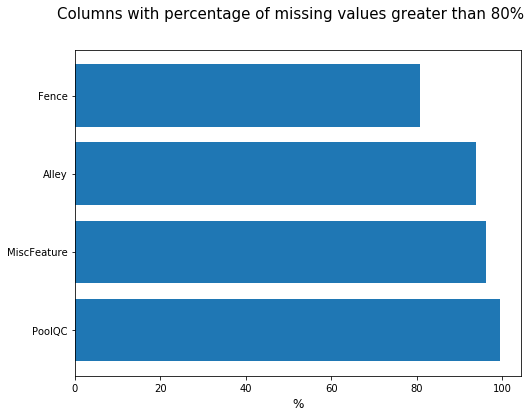

In [4]:
thresh = .8
nulls = df.isna().sum()

fig = plt.figure(figsize=(8, 6))
plt.barh(nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False).index, 
         (nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False)/df.shape[0]*100).values)
fig.suptitle('Columns with percentage of missing values greater than 80%', fontsize=15)
plt.xlabel('%', fontsize=12)
plt.show();

This plot suggests we should drop Alley, PoolQC, Fence, MiscFeature because they are over 80% null.
Upon looking at the data dict however, you'll see that the NAs represent the case where a house does not have a given feature, and are not actually `nulls`. 
Let this be a reminder to understand what the data represents.

### Fill missing values

In [5]:
# Separate out columns by data type to fill in missing values
numerical_columns = df.select_dtypes(include=[np.int64, np.float64])
categorical_columns = df[df.select_dtypes(include=['category']).columns.union(['Id'])]

# Interpolate the two integer fields using linear interpolation
numerical_columns = numerical_columns.interpolate()

# Handling the two fields where the NaNs do not correspond to a known value.
# Fields 'Electrical' and "MasVnrType" have 8 and 1 missing values respectively. Since these are two fields
# where the NaN does not correspond to a value, and since there are so few records, we're dropping those.
categorical_columns = categorical_columns[~categorical_columns['Electrical'].isna()]
categorical_columns = categorical_columns[~categorical_columns['MasVnrType'].isna()]

# adding 'None' category to categorical fields, and then replacing NaN with 'None' so the records can be used in models
def add_category(df, col):
    df[col].cat.add_categories('None', inplace=True)

# identify number of nulls per column
null_categorical = categorical_columns.isna().sum().sort_values(ascending=False).reset_index()
null_categorical = null_categorical[null_categorical['index'] != 'Id']

# for each row in series, if there are n_nulls > 0, add 'None' as category and fill nulls with 'None'
for index, row in null_categorical.iterrows():
    if row[0] > 0:
        add_category(categorical_columns, row['index'])
        categorical_columns[row['index']] = categorical_columns[row['index']].fillna(value='None')

### Check for correlated variables

To aid in identifying what degree of correlation between predictors we are willing to accept, we'll run an SVD and look at how much variance is captured by the first few components, and use that to guide our covariance threshold.

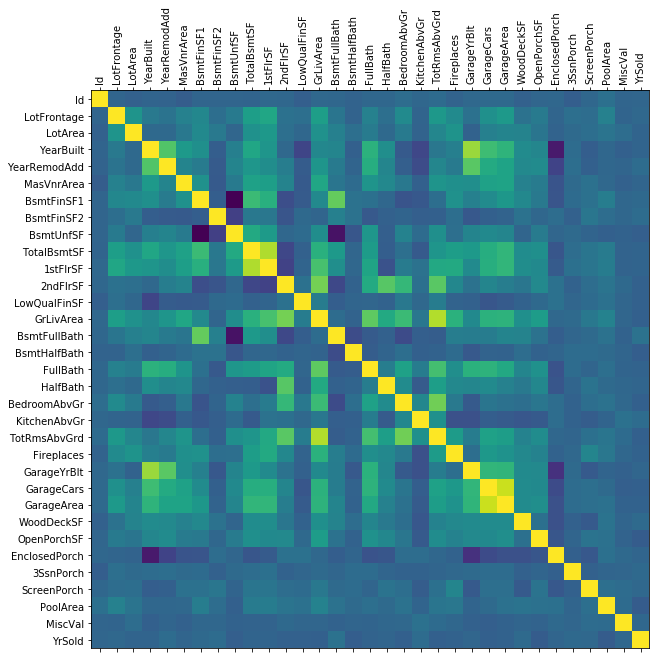

In [6]:
labels = numerical_columns.columns
corr_matrix = numerical_columns.corr()

corr_plt = plt.figure(figsize=(10,10))
plt.matshow(corr_matrix, fignum=corr_plt.number)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(labels)), labels);

From a visual inspection, it looks like the following pairs predictors are the most strongly correlated:

- GarageYrBlt, YearBuilt
- 1stFlrSF, TotalBsmtSF
- GarageArea, GarageCars
- TotRmsAbvGrd, GrLivArea

Let's set a threshold of 75% 

In [7]:
threshold = .75

# create matrix with upper triangle and lower triangle (below the kth diagonal) distinguished by a bool 
empty_upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)

# filter the correlation matrix using empty_upper
corr_matrix_upper = corr_matrix.where(empty_upper)

# identify columns whose correlation coef is gt than the threshold
high_corr_cols = [col for col in corr_matrix_upper.columns if any(corr_matrix_upper[col] > .75)]
high_corr_cols
for each in high_corr_cols:
    filtering = corr_matrix[each] > threshold
    other = np.setdiff1d(filtering[filtering].index, each)[0]
    print(each, ',', other, ',',corr_matrix.loc[each, other])

# Dropping these highly correlated features just for the linear models
lin_numerical_columns = numerical_columns.drop(high_corr_cols, axis=1)

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']

1stFlrSF , TotalBsmtSF , 0.8195299750050355
TotRmsAbvGrd , GrLivArea , 0.8254893743088377
GarageYrBlt , YearBuilt , 0.7750117909723675
GarageArea , GarageCars , 0.8824754142814603


### Identifying and removing non-linear features 

If there are any non-linear features, they will be removed just for the linear models. We'll utilize the full dataset for non-linear models in the future.

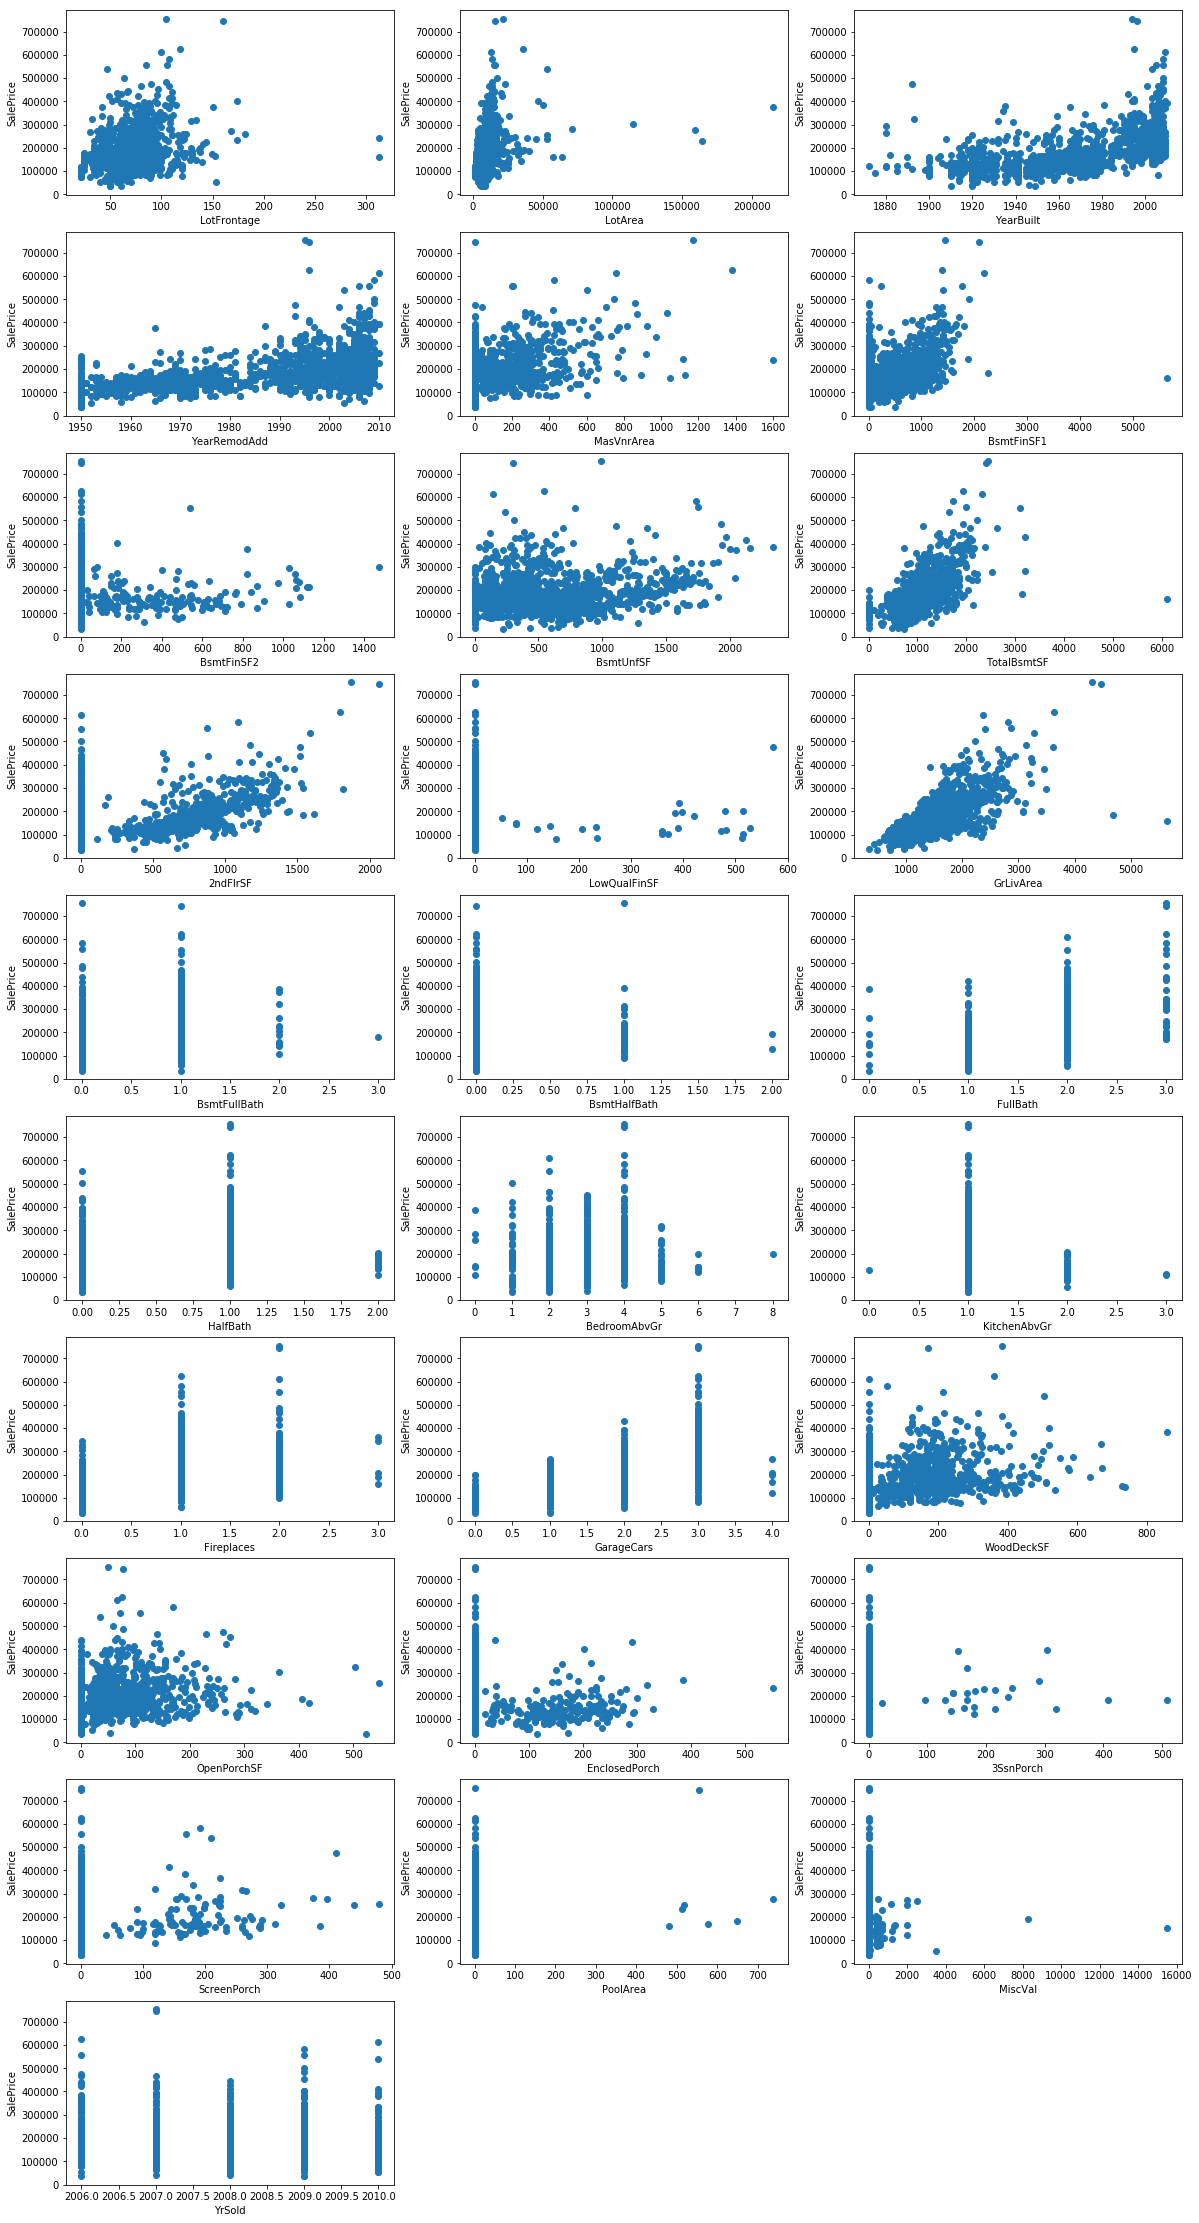

In [8]:
nrows=10
fig_lin_cols, ax = plt.subplots(nrows, 3, figsize=(20,40));

for j, col in enumerate(lin_numerical_columns.columns[1:]):
    _ = ax[j//3][j%3].scatter(lin_numerical_columns[col], Y)
    _ = ax[j//3][j%3].set_ylabel('SalePrice')
    _ = ax[j//3][j%3].set_xlabel(col);

# remove last two unused plots
ax[j//3][1].set_axis_off()
ax[j//3][2].set_axis_off()

Based on these plots, it looks like the following predictors have a non-linear relationship with the target: 

'LotFrontage', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF', 
                   'EnclosedPorch', 'OpenPorchSF', 'MiscVal', 'PoolArea', '3SsnPorch'

In [9]:
non_linear_cols = ['LotFrontage', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF', 
                   'EnclosedPorch', 'OpenPorchSF', 'MiscVal', 'PoolArea', '3SsnPorch']
lin_numerical_columns.drop(non_linear_cols, axis=1, inplace=True)

### Join dataframes back together

In [10]:
lin_processed_df = lin_numerical_columns.join(categorical_columns.set_index('Id'), on='Id').drop(['Id'], axis=1)
X = pd.get_dummies(lin_processed_df, drop_first=True)

### Split data into Train, Test, Validation

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=.8, random_state=random_state)
test_X, val_X, test_Y, val_Y = train_test_split(test_X, test_Y, train_size=.8, random_state=random_state)

### Utils

In [12]:
def eval_model(metrics):
    global model_performance
    if 'model_performance' not in globals():
        model_performance = pd.DataFrame(data={'model': [metrics[0]],'data': [metrics[1]],'R**2_train':[metrics[2]],'R**2_test':[metrics[3]],'RMSE':[metrics[4]]})
    else:
        model_performance = model_performance.append({'model': metrics[0],'data': metrics[1],'R**2_train':metrics[2],'R**2_test':metrics[3],'RMSE':metrics[4]},
                                                 ignore_index=True)
        model_performance = model_performance.drop_duplicates(subset=['model', 'data', 'R**2_train', 'R**2_test', 'RMSE'])

### Predicting with linear models

In [13]:
# perform standardization of the data
# Center the data so the mean = 0, and stdev = 1
scalar_X = RobustScaler() # StandardScaler()

X_scaled = scalar_X.fit_transform(train_X)
test_X_scaled = scalar_X.transform(test_X)

# normalizing using the L2 norm 
# X_scaled = normalize(X_scaled, norm='l2')
# test_X_scaled = normalize(test_X_scaled, norm='l2')


In [14]:
# fit linear regression on X (original with dummy variables for categorical)
reg_lm_raw = lm.LinearRegression().fit(train_X, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_lm_raw.score(train_X, train_Y), '\n')

# fit linear regression on standardized and normalized data
reg_lm_scaled = lm.LinearRegression().fit(X_scaled, train_Y)
print('Prediction score of simple linear regression on scaled and normalized data: ', reg_lm_scaled.score(X_scaled, train_Y))

Prediction score of simple linear regression on raw data:  0.9416137573562272 

Prediction score of simple linear regression on scaled and normalized data:  0.9416137573562272


Scaling and normalizing the data did not yield a better prediction accuracy for the simple linear regression, but will be necessary for additional models used below. We'll primarily use X_scaled going forward.


### Predicting with the LASSO

In [15]:
# Lasso Regression | L1 norm aka sum(abs(Beta)). Regularizes the loss with lambda*sum(abs(Beta))
reg_lasso = lm.Lasso(alpha=5, 
                     fit_intercept=True, 
                     normalize=False, 
                     max_iter=10000
                    )\
              .fit(X_scaled, train_Y)

reg_lasso.score(X_scaled, train_Y)

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8942309245.769653, tolerance: 733856567.5686355
  positive)


0.9368715890619831

With just an alpha of 5, this model achieved a similar R^2 to the simple linear regression. Let's get a sense of how many input features can be dropped while still maintaining an acceptable model performance.

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50274866168.2666, tolerance: 733856567.5686355
  positive)
/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46023156292.009766, tolerance: 733856567.5686355
  positive)


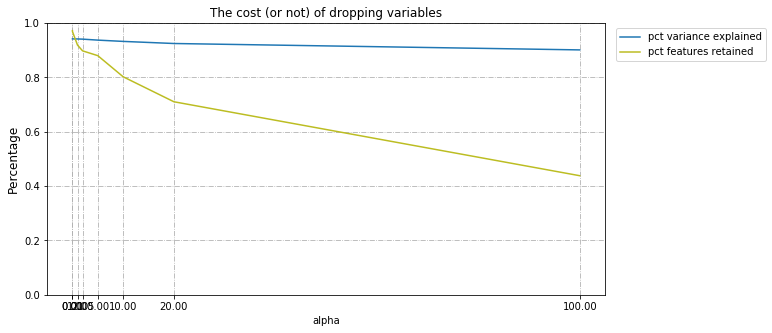

This plot shows that a penalty factor of alpha = 100 which drops about 56% of the input features 
would cost a -4.06 percentage point drop in captured variance. Below we'll compare the performance of the
lasso with alpha = 5 and alpha = 100.


In [16]:
regressions = []
scores = []
alphas = [.0001, .01, 1, 2, 5, 10, 20, 100] # np.arange(5, 100, 2)

for a in alphas:
    regression = lm.Lasso(alpha=a, 
                          fit_intercept=True, 
                          normalize=False, 
                          max_iter=100000
                         )\
                   .fit(X_scaled, train_Y)
    regressions.append(regression)
    scores.append(regression.score(X_scaled, train_Y))

# plt.figure()
fig, ax = plt.subplots(figsize=(10, 5))
color = 'tab:blue'
line1 = ax.plot(alphas, scores, color=color, label='pct variance explained')
_ = plt.xticks(alphas)
_ = plt.grid(True, linestyle='-.')
_ = plt.xlabel('alpha')
_ = plt.ylim([0, 1])
_ = plt.ylabel('Percentage', color='black', size=12)
_ = plt.title('The cost (or not) of dropping variables')

# collections.Counter returns dict with counts of each value in list. Using to get counts of 0
coefs = [collections.Counter(x.coef_)[0]/len(x.coef_) for x in regressions]

color = 'tab:olive'
line2 = ax.plot(alphas, 1 - np.array(coefs), color=color, label='pct features retained')
# plt2.set_ylabel('Fraction of features retained', color=color, size=12)
_ = plt.legend(bbox_to_anchor=(1.01,1))
plt.show();

print(f"This plot shows that a penalty factor of alpha = {max(alphas)} which drops about {np.round(coefs[-1]*100,0).astype(int)}% of the input features \nwould cost a {np.round((scores[-1] - scores[0]) * 100, 2)} percentage point drop in captured variance. Below we'll compare the performance of the\nlasso with alpha = 5 and alpha = {max(alphas)}.")


In [17]:
# Lasso Regression with alpha=19
a = max(alphas)
lasso_41 = lm.Lasso(alpha=a, fit_intercept=True, max_iter=10000).fit(X_scaled, train_Y)
lasso_41.score(X_scaled, train_Y)

0.9010293537623761

### Evaluate generalizability of lasso and simple linear regression

In [18]:
eval_model(['OLS','raw, unprocessed data', reg_lm_raw.score(train_X, train_Y), reg_lm_raw.score(test_X, test_Y), mean_squared_error(test_Y, reg_lm_raw.predict(test_X), squared=False),])
eval_model(['OLS','standardized and normalized data', reg_lm_scaled.score(X_scaled, train_Y),reg_lm_scaled.score(test_X_scaled, test_Y), mean_squared_error(test_Y, reg_lm_scaled.predict(test_X_scaled), squared=False)])
eval_model(['LASSO','standardized and normalized data', reg_lasso.score(X_scaled, train_Y), reg_lasso.score(test_X_scaled, test_Y), mean_squared_error(test_Y, reg_lasso.predict(test_X_scaled), squared=False),])
eval_model([ 'LASSO-41', 'standardized and normalized data', lasso_41.score(X_scaled, train_Y), lasso_41.score(test_X_scaled, test_Y), mean_squared_error(test_Y, lasso_41.predict(test_X_scaled), squared=False)])
model_performance


,model,data,R**2_train,R**2_test,RMSE
0,OLS,"raw, unprocessed data",0.942,0.581,54702.753
1,OLS,standardized and normalized data,0.942,0.581,54702.753
2,LASSO,standardized and normalized data,0.937,0.858,31821.291
3,LASSO-41,standardized and normalized data,0.901,0.869,30594.583


Both the R^2 value and the Mean Squared Error of the linear regression on scaled data is deep in the negatives as we can see. The model's performance on the scaled test set appears to have suffered more of a performance hit than the LASSO analysis, which dropped 50% of the input features. 

### Singular Value Decomposition

This section will explore using SVD as a method to perform dimensionality reduction on the data and using the resulting components as inputs to a linear regression.

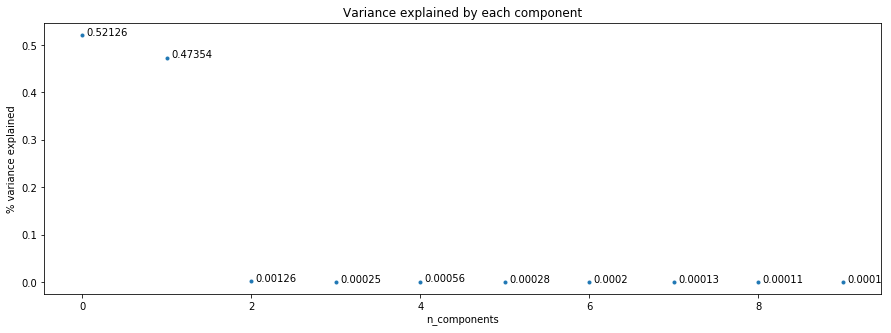

In [19]:
n_components = 10

SVD = TruncatedSVD(n_components=n_components, algorithm='randomized', random_state=random_state)
SVD.fit(X_scaled)
X_SVD_transformed = SVD.transform(X_scaled)
fig, ax = plt.subplots(figsize=(15, 5), facecolor='w', edgecolor='k')
plt.plot(range(n_components), SVD.explained_variance_ratio_, '.')
for i, ratio in enumerate(SVD.explained_variance_ratio_):
    ax.annotate(str(np.round(ratio, decimals=5)), xy=(i + .05, ratio))
plt.title('Variance explained by each component')
plt.xlabel('n_components')
plt.ylabel('% variance explained')
plt.show();

In [20]:
print(f"Amount of variance captured by first two components is: {np.round(sum(SVD.explained_variance_ratio_[:2]), 4)}")

Amount of variance captured by first two components is: 0.9948


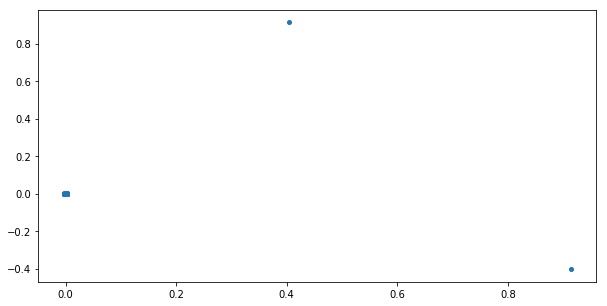

In [35]:
_ = plt.figure(figsize=(10,5))
_ = plt.plot(SVD.components_[0], SVD.components_[1], '.')

In [22]:
# fit linear regression on first 10 components given by the SVD's singular values.
SVD_10 = pd.DataFrame(X_SVD_transformed).iloc[:,0:11]
reg_SVD = lm.LinearRegression().fit(SVD_10, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_SVD.score(SVD_10, train_Y))
print(f"\nInterestingly, the first 10 components explain only {np.round(sum(SVD.explained_variance_ratio_[:11]) * 100, 2)}% of the variance in the data,\nyet yield a model accuracy of {np.round(reg_SVD.score(SVD_10, train_Y), 4)}.\n\nI\'ll include another 20 components to see if that will improve model performance.")

Prediction score of simple linear regression on raw data:  0.746343019503199

Interestingly, the first 10 components explain only 99.77% of the variance in the data,
yet yield a model accuracy of 0.7463.

I'll include another 20 components to see if that will improve model performance.


In [23]:
SVD_30 = pd.DataFrame(X_SVD_transformed).iloc[:,0:31]
reg_SVD_30 = lm.LinearRegression().fit(SVD_30, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_SVD_30.score(SVD_30, train_Y))
print('By including 20 more components in this regression, the model is able to capture 4% more variance in the features.')


Prediction score of simple linear regression on raw data:  0.746343019503199
By including 20 more components in this regression, the model is able to capture 4% more variance in the features.


### Evaluate generalizability of linear regression + SVD 
ie. the performance of a linear regression on the singular vectors given by the Singular Value Decomposition

In [24]:
SVD_test = SVD.transform(test_X_scaled)
SVD_10_test = pd.DataFrame(SVD_test).iloc[:,0:11]
SVD_30_test = pd.DataFrame(SVD_test).iloc[:,0:31]

In [25]:
eval_model(['SVD-10', 'first 10 components given by the singular values', reg_SVD.score(SVD_10, train_Y), reg_SVD.score(SVD_10_test, test_Y), mean_squared_error(test_Y, reg_SVD.predict(SVD_10_test), squared=False)])
eval_model(['SVD-30','first 30 components given by the singular values',reg_SVD_30.score(SVD_30, train_Y),reg_SVD_30.score(SVD_30_test, test_Y), mean_squared_error(test_Y, reg_SVD_30.predict(SVD_30_test), squared=False)])

model_performance

,model,data,R**2_train,R**2_test,RMSE
0,OLS,"raw, unprocessed data",0.942,0.581,54702.753
1,OLS,standardized and normalized data,0.942,0.581,54702.753
2,LASSO,standardized and normalized data,0.937,0.858,31821.291
3,LASSO-41,standardized and normalized data,0.901,0.869,30594.583
4,SVD-10,first 10 components given by the singular values,0.746,0.807,37123.163
5,SVD-30,first 30 components given by the singular values,0.746,0.807,37123.163


### Regression with ElasticNet

In [26]:
# Elasticnet: uses both the Ridge and Lasso penalties. Drawback of Lasso is that if there are a number of correlated 
# variables, it will only select one, and deselect for the rest. 


\begin{equation*}
{\hat {\beta }}\equiv {\underset {\beta }{\operatorname {argmin} }}(\|y-X\beta \|^{2}+\lambda _{2}\|\beta \|^2_2+\lambda _{1}\|\beta \|_{1})
\end{equation*}

scikit-learn's elasticnet implementation allows you to attribute weights (which sum to 1) to each of the penalties. Setting $l1_{ratio} = 1 $ will apply the Lasso, or $L1$ norm, penalty and setting $l1_{ratio} = 0$ will apply the Ridge, or $L2$ norm penalty. When $0 < l1_{ratio} < 1$ will apply some fraction of both penalties. The following is the objective function the implementation aims to minimize

\begin{equation*}
{\frac{1}{2*n_{samples}} * ||y - X\beta||^2_2
+ \alpha * l1_{ratio} * ||\beta||_1
+ 0.5 * \alpha * (1 - l1_{ratio}) * ||\beta||^2_2}
\end{equation*}

In [27]:
# Start with the default implementation on the scaled input used for Lasso above.
# The data must be Fortran-contiguous. Checking X_scaled.flags verifies that this condition is met.

ElastNet = lm.ElasticNet(random_state=17)
ElastNet.fit(X_scaled, train_Y)
ElastNet.score(X_scaled, train_Y)
predictions_elastnet = ElastNet.predict(X_scaled)
testpredictions_elastnet = ElastNet.predict(test_X_scaled)

ElasticNet(random_state=17)

0.7684290847308726

In [28]:
mean_squared_error(testpredictions_elastnet, test_Y)

1470901124.5515373

We're looking at a relatively unremarkable performance out of the box. Let's tune the model.

In [29]:
# Increase max_iter to give the model the opportunity to converge
# Increase alpha from 1 to 10
# increase the weight of the lasso penalty (the l1 norm)

ElastNet2 = lm.ElasticNet(alpha=10,l1_ratio=.75, fit_intercept=True, selection='cyclic', max_iter=1000000, tol=0.000001, random_state=random_state)
ElastNet2.fit(X_scaled, train_Y)
ElastNet2.score(X_scaled, train_Y)


ElasticNet(alpha=10, l1_ratio=0.75, max_iter=1000000, random_state=10,
           tol=1e-06)

0.6086728882843584

Well.... this second implementation of ElasticNet captured considerably less variance in the feature set than the first.

In [30]:
eval_model(['ElasticNet', 'standardized and normalized data', ElastNet.score(X_scaled, train_Y), ElastNet.score(test_X_scaled, test_Y), mean_squared_error(test_Y, ElastNet.predict(test_X_scaled), squared=False)])
eval_model(['ElasticNet', 'raw, unprocessed data', ElastNet2.score(X_scaled, train_Y), ElastNet2.score(test_X_scaled, test_Y), mean_squared_error(test_Y, ElastNet2.predict(test_X_scaled), squared=False)])
model_performance


,model,data,R**2_train,R**2_test,RMSE
0,OLS,"raw, unprocessed data",0.942,0.581,54702.753
1,OLS,standardized and normalized data,0.942,0.581,54702.753
2,LASSO,standardized and normalized data,0.937,0.858,31821.291
3,LASSO-41,standardized and normalized data,0.901,0.869,30594.583
4,SVD-10,first 10 components given by the singular values,0.746,0.807,37123.163
5,SVD-30,first 30 components given by the singular values,0.746,0.807,37123.163
6,ElasticNet,standardized and normalized data,0.768,0.794,38352.329
7,ElasticNet,"raw, unprocessed data",0.609,0.621,52031.613


# Future work: TBD

- random forests
- gradient boosting
- neural net

### Regression with Random Forests

So far we have looked at various types of linear models with and without penalties. Next we'll explore the performance of a non-linear model - Random Forests.

In [31]:
# rfr = RandomForestRegressor()
# rfr.fit(train_X)